In [ ]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import pandasql as psql
sql=psql.sqldf
import numpy as np
sns.set_style("dark")
from wordcloud import WordCloud, STOPWORDS
!pip install pywaffle
from pywaffle import Waffle
sns.set_palette("pastel")


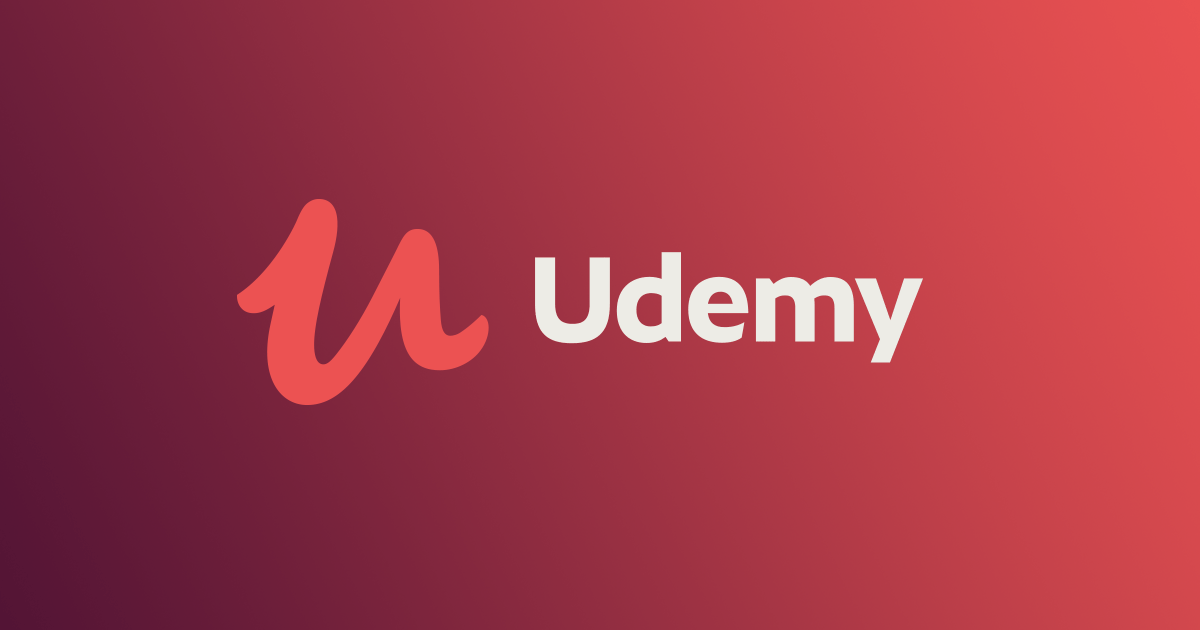

# Udemy is an online learning and teaching marketplace with over 100000 courses and 24 million students. We are going to investigate the data using Pandas & SQL and show some insights about its courses! I'll also integrate a Tableau Dashboard (in development) in the end.

# Hope you like it!




In [ ]:
PATH = "../input/udemy-courses/"

df = pd.read_csv(PATH + 'udemy_courses.csv')
head=df.head(100)
head

In [ ]:
#Checking the columns that we have
column=df.columns
column

In [ ]:
#Let's drop the column that is not relevant for our EDA
df=df.drop(['course_id'],axis=1)
df.head(5)

In [ ]:
#Checking Missing Data
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

missing=missing_data(df)
missing

# Data look clean! That's cool!

# Let's adjust the content duration column - there are some weird values there such as "Question", "beginner level" and hours/min

In [ ]:
#Removing the string "hour"
df['content_duration']=df['content_duration'].astype(str).str.replace('hours','')
df['content_duration']=df['content_duration'].astype(str).str.replace('hour','')
#Transforming minutes in hours
df.loc[df['content_duration'].str.contains('mins')==True,'content_duration']=df.loc[df['content_duration'].str.contains('mins')==True,'content_duration'].str.replace('mins','').astype('float')/60


In [ ]:
#Excluding strange values such as "question" "beginner level" from the df.
df=sql('''select * from df where content_duration not like ("%question%") and content_duration not like ("%Beginner Level%")''')

df['content_duration']=df['content_duration'].astype('float').round(2)

df['content_duration'].unique()

# Content duration values are now fine.

In [ ]:
#Creating a date column using pd.datetime -  (it can be useful when we create our Tableau Dash.)
df['date']= pd.to_datetime(df['published_timestamp'], format = '%Y-%m-%d')
df['year']=df['date'].dt.year
df['month']=df['date'].dt.month

In [ ]:
#Transforming Price to Float and cleaning if necessary
df['price'].unique()
df['price']=df['price'].replace('Free','0').astype(float)

In [ ]:
#Ok good enough - let's start plotting the number of costs paid/free
Free_or_not=sql('''select is_paid,count(is_paid) from df 
                                                group by is_paid''')
print(Free_or_not)
#We can see that we need to adjust the False and True - we have different variations.
df['is_paid']=df['is_paid'].replace('False','FALSE')
df['is_paid']=df['is_paid'].replace('True','TRUE')

#Checking..
Free_or_not=sql('''select is_paid,count(is_paid) as "Values" from 
                                            df group by is_paid''')
plt.figure(figsize=(12,6))
sns.barplot(x='is_paid',y='Values',data=Free_or_not)
plt.xticks(rotation=90)
plt.title("There ain't no such thing as a free lunch", fontsize = 22)
plt.ylabel('Amount of courses', fontsize = 20)
plt.xlabel('Paid', fontsize = 20)

# There is not such thing as free lunch...

In [ ]:
#Courses by Topic?
courses_by_topic=sql('''select subject, count(course_title) as courses, is_paid
                     from df
                     group by subject, is_paid''')
sns.catplot(y='subject',x='courses',col='is_paid',kind='bar',data=courses_by_topic)



Web Development and Business Finance Courses are the most popular in Udemmy

In [ ]:
#Calculating the % by Subject using SQL and then a Waffle Chart
courses_per=sql('''select subject, 100.*count(course_title)/sum(count(course_title)) over () as Share
              from df
              group by subject
              order by Share desc''')
                          
waffle=plt.figure(
    FigureClass=Waffle,
    rows=6,
    columns=10,
    values=courses_per.Share,
    labels=list(courses_per.subject),
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    figsize=(16,5)
)
print(courses_per)

# Web Development = 33%
# Business Finance 33%
# Musical Instruments = 18%
# Graphic Design = 16%

In [ ]:
plt.figure(figsize=(25,10))
sns.catplot(x='price',y='subject',data=df,kind='violin')
plt.title('Price Distribution per Subject',fontsize = 22)

In [ ]:
#What are the most popular courses? Let's Check the Top 20
popular_courses=sql('''select course_title,subject, sum(num_subscribers) as Subs from df
                                                                        group by course_title, subject 
                                                                        order by Subs Desc limit 20''')
plt.figure(figsize=(12,6))
sns.catplot(x='Subs',y='course_title',hue='subject',data=popular_courses)
plt.xticks(rotation=90)
plt.title("Top 20 Courses by #Subs", fontsize = 22)
plt.ylabel('Course Name', fontsize = 20)
plt.xlabel('Number of Subs', fontsize = 20)

# Top 20 is dominated by the Web Dev topic - Learn HTML5 from Scratch has a immense amount of Subs.
# There are only 2 topics outside of Web Dev in the top 20

In [ ]:
#Let's see the number of subs by level?
popular_course_level=sql('''select course_title,subject,level, sum(num_subscribers) as Subs from df 
                                                                where level not like ('%All%') 
                                                                group by course_title, subject,level 
                                                                order by Subs desc''')
plt.figure(figsize=(12,6))
g=sns.catplot(x='subject',y='Subs',col='level',data=popular_course_level)
g.set_xticklabels(rotation=65, horizontalalignment='right')


# Beginner Levels have more subs - which makes sense.

In [ ]:
#Beginner level courses are more popular. Are they cheaper as well?

beginner=sql('''select course_title, subject,level,price 
             from df
         
             group by course_title,subject,level 
             order by price desc''')
             
plt.figure(figsize=(12,6))
sns.catplot(x='price',y='subject',col='level',kind='box',data=beginner)
plt.xticks(rotation=90)

In [ ]:
#What are the courses with more content? Let's Check the Top 20
contenttop20=sql('''select course_title,subject, sum(content_duration) as content_duration from 
                    df group by course_title, 
                    subject 
                    order by content_duration desc limit 20''')
plt.figure(figsize=(12,6))
sns.scatterplot(x='content_duration',y='course_title',hue='subject',data=contenttop20)
plt.title("Top 20 Content Duration Courses", fontsize = 22)
plt.ylabel('Course Name', fontsize = 20)
plt.xlabel('Content Duration in Hours', fontsize = 20)

# Drawing must be really hard :)

In [ ]:
#Correlation between the variables?
corr=df.iloc[:,:12].corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize=(15,10))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation between the variables',fontsize=22)

Number of Subscribes have a moderate correlation with number of review.
Prices also have a moderate correlation with Number of Lectures and Content Duration - which also makes sense. The author of the course has to charge more since he/she spent more time creating the course.

In [ ]:
#We have date information - let's try to extract something from there..

#courses published?

per_year=sql('''select year,subject, sum(count(course_title)) over (partition by year, subject) as NumberofCourses 
             from df 
             group by year,subject
             order by year''')

plt.figure(figsize=(15,6))
g2=sns.barplot(x='year',y='NumberofCourses',data=per_year,hue='subject')
plt.title('Courses per Year',fontsize=22)    
plt.legend(loc='upper left')      
plt.xticks(rotation=90)

# I used the window function from SQL which is very useful to do this kind of analysis - you can find more details here https://mode.com/sql-tutorial/sql-window-functions/

In [ ]:
#Code taken from https://www.kaggle.com/sayar1106/comprehensive-eda-on-udemy-data - Sayar

comment_words = ''
stopwords = set(STOPWORDS)

for s in df.course_title:
    s = str(s)
    tokens = s.split()
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='black', 
            stopwords = stopwords, 
            min_font_size = 10).generate(comment_words)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# These are the main words when we analyze the course_titles column. Beginners seems to appear a lot and this reflect what we have seen so far on our analysis!

Tableau Viz - https://public.tableau.com/views/Udemy_15900586631370/Dashboard1?:retry=yes&:display_count=y&:origin=viz_share_link

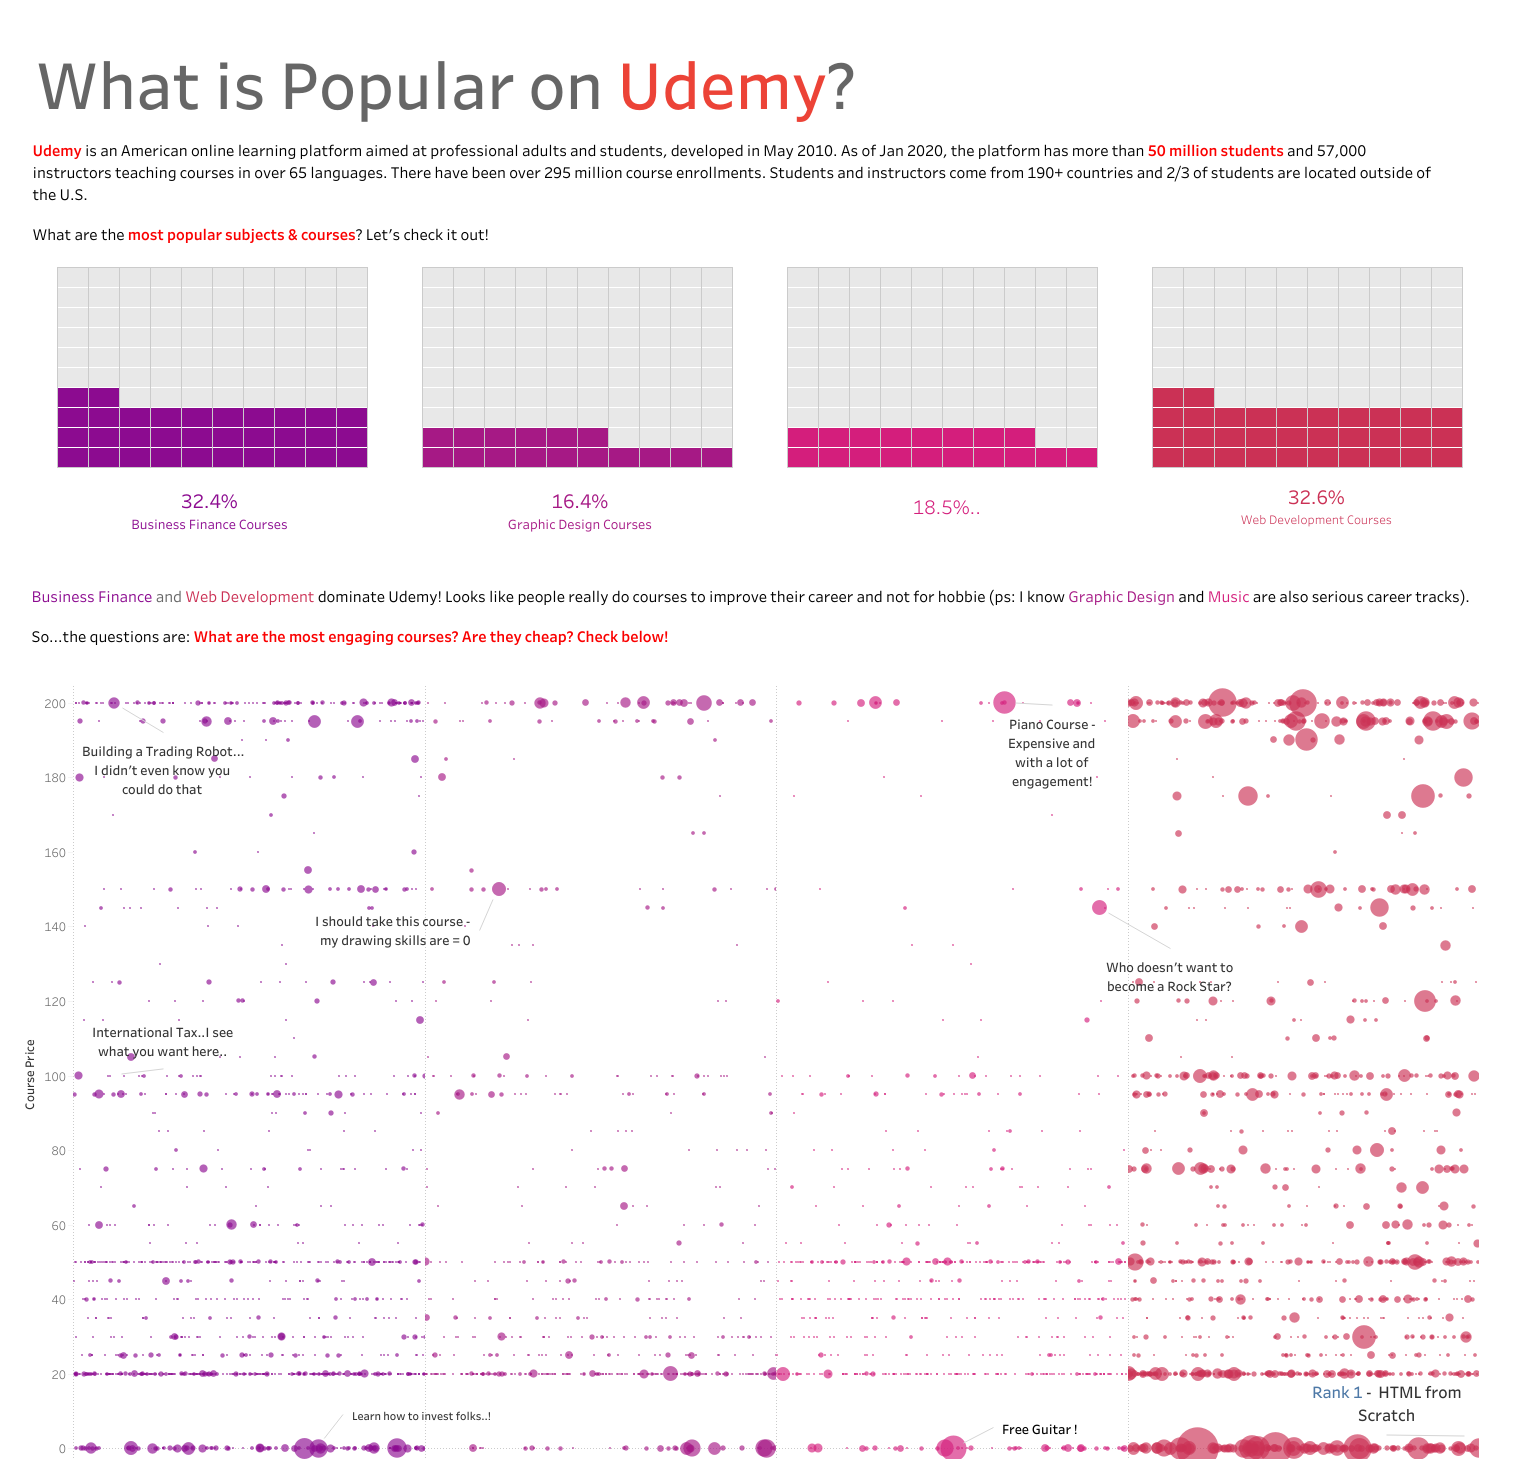

